Here you will use remote sensing data collected from the Sentinel-2 satellite to find crops. Algorithms that can identify crops are helpful in assessing land use changes associated with agriculture. 

Sentinel-2 collects data in 13 spectral bands (regions of the electromagnetic spectrum), as shown here:
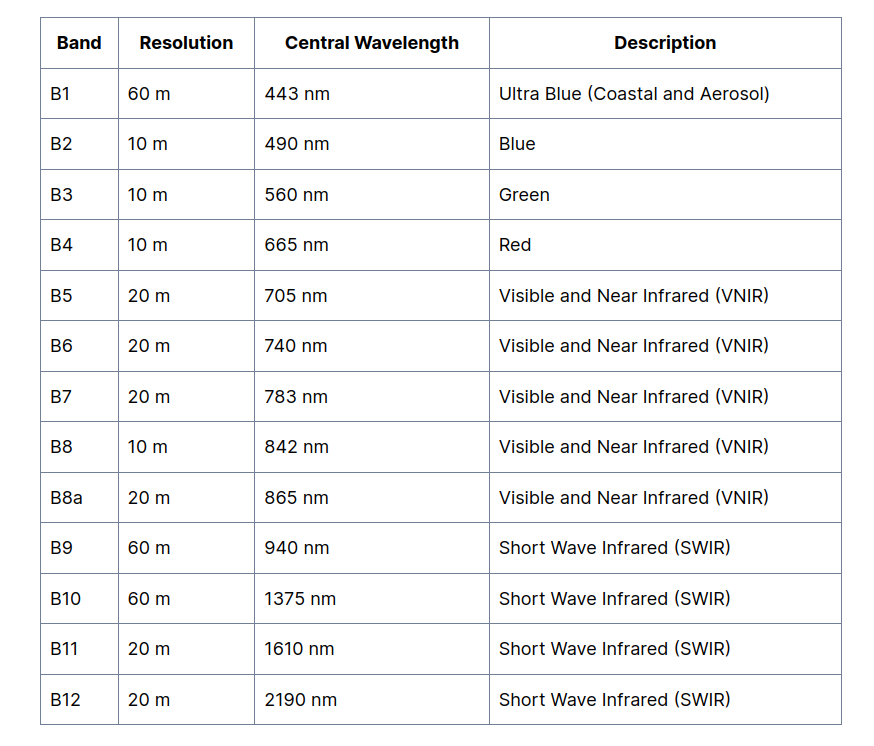

To identify crops, some bands are more helpful than others. For example, B2-B4 are the visible spectrum and reflect what we see, near-infrared wavelengths can be sensitive to chlorophyll and short wave infrared (SWIR) wavelengths are sensitive to water content. Bands such as B1 and B10, however, respond more to clouds and particles in the air and are therefore less useful here. 

Scientists also create indices for certain purposes. These indices are combinations of values from different bands. For our purposes, the normalized difference vegetation index (NDVI) will be helpful as it is specifically suited to identifying plants. It is calculated as:

$$ NDVI = (B8 - B4) / (B8 + B4) $$

We will use data collected from the Togolese Republic (as described in [this paper](https://arxiv.org/pdf/2006.16866.pdf), with data accessed through [this repo](https://github.com/nasaharvest/cropharvest)). 

The data contains 1290 data points in the training set and 306 in the test set. Each data point represents one spatial location, and contains all Sentintel-2 bands except B1 and B10 plus the pre-calculated NDVI. Therefore, each data point has 12 features in total. Each point is labeled as containing crops (1) or not (0).   

Download the npz [here](https://drive.google.com/file/d/14jJCC0srUmoAIWWOESE-s4mWbMq3OrH9/view?usp=sharing) and unpack it as below. 

In [3]:
# Import packages and libraries 
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
# Load the data 
data_path = 'togo_crops_data.npz'
data = np.load(data_path)
X_train = data['arr_0']; y_train = data['arr_1']; X_test = data['arr_2']; y_test = data['arr_3']

Plot histograms of the training values of each feature. Specifically, for each feature, make a single plot that contains two histograms: one of the values for locations with crops and one for those without *(1 pt)*. Set the bins the same for each *(.5 pt)* and reduce the transparency of each so that both are visible *(.5 pt)*. E.g., they should look something like this: 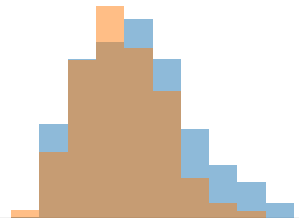

Based on these plots, do you think the first feature would be useful for identifying crops? What about the 8th? *(.5 pt each)*


In [36]:
# Create dataframes to plot 
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_df = pd.concat([X_train_df, y_train_df], axis=1, ignore_index=True)
train_df.columns = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4',
                    'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8',
                    'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Location']

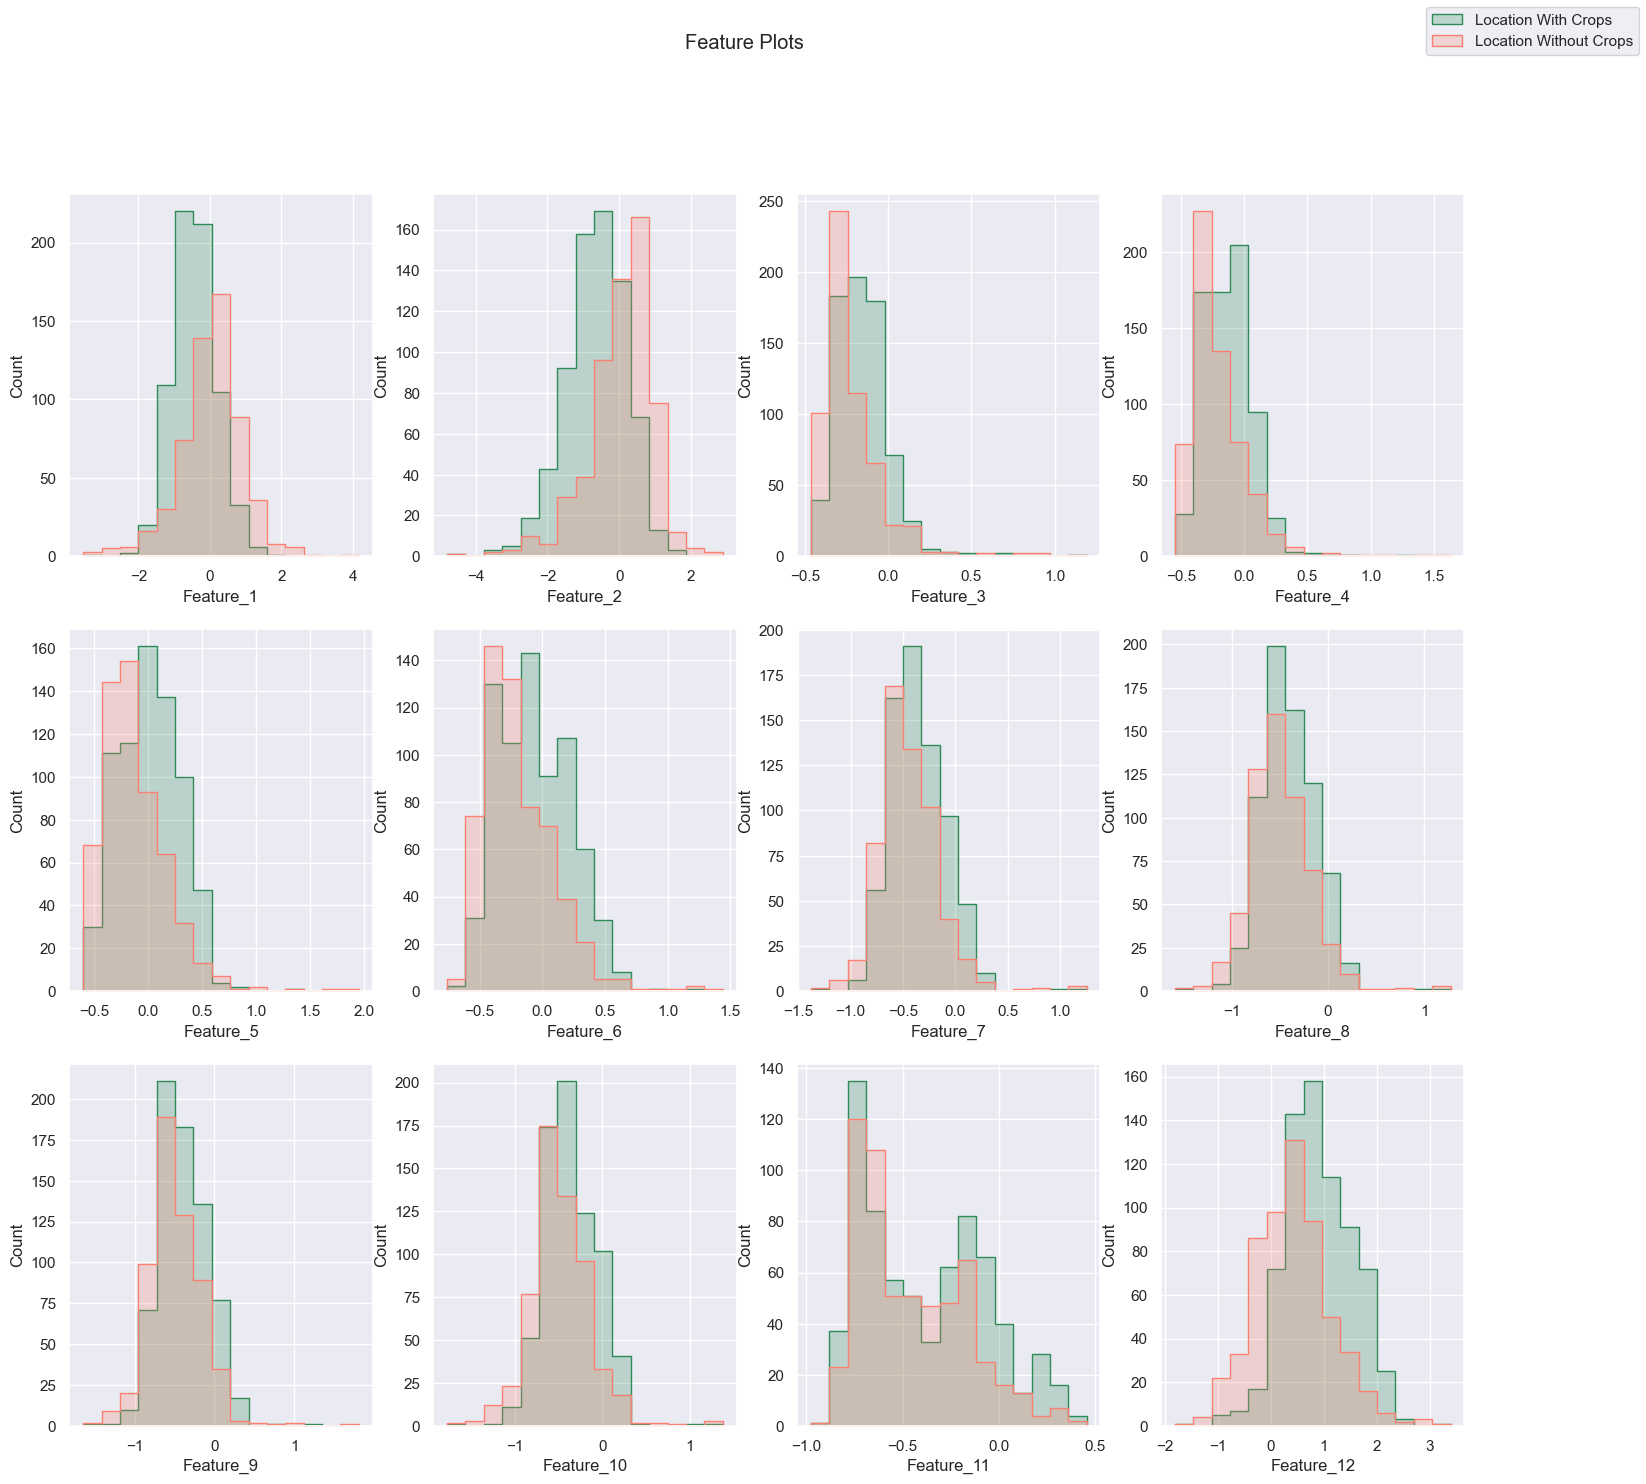

In [96]:
# Create histogram plot 

# Set seaborn figure and palette 
sns.set(style="darkgrid")
palette = ["salmon", "seagreen"]
fig, axs = plt.subplots(3, 4, figsize=(18, 16))
fig.suptitle('Feature Plots')

# Plot each feature
sns.histplot(data=train_df, x="Feature_1", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[0, 0])

sns.histplot(data=train_df, x="Feature_2", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[0, 1])

sns.histplot(data=train_df, x="Feature_3", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[0, 2])

sns.histplot(data=train_df, x="Feature_4", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[0, 3])

sns.histplot(data=train_df, x="Feature_5", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[1, 0])

sns.histplot(data=train_df, x="Feature_6", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[1, 1])

sns.histplot(data=train_df, x="Feature_7", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[1, 2])

sns.histplot(data=train_df, x="Feature_8", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[1, 3])

sns.histplot(data=train_df, x="Feature_9", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[2, 0])

sns.histplot(data=train_df, x="Feature_10", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[2, 1])

sns.histplot(data=train_df, x="Feature_11", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[2, 2])

sns.histplot(data=train_df, x="Feature_12", hue="Location", element='step',
             bins=15, legend=False, palette=palette, ax=axs[2, 3])

# Add legend 
plt.figlegend(["Location With Crops", "Location Without Crops"])
plt.show()


Train a logistic regression model on the training data to classify each data point as containing crops or not *(1 pt)*. Evaluate the model separately on both the training and test set according to the overall classification accuracy. Because this a binary classification model, we can also use more fine-grained measures of performance such as [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). Evaluate the model on these metrics as well *(.5 pt for each metric for training and test - 3 pts total)*. 


Looking at the results on the test data, which is your model better at: catching true crops that exist or not labeling non-crops as crops? *(1 pt)*

Create two new data sets from this data: one that only contains the 2nd through 11th features and one that contains the remaining three features *(.5 pt for each)*. Train two new logistic regression models with these two new datasets and report their test accuracy *(.5 pt for each)*. In this case, does the model with more features perform better? Why or why not? *(1pt)*